In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import string
import numpy as np
import easyocr
import collections
from PIL import Image, ImageColor, ImageDraw, ImageFont
from matplotlib import pyplot as plt
from pprint import pprint
from tqdm import tqdm

# Define OCR

In [53]:
# Initialize OCR
reader = easyocr.Reader(['en'], gpu=True)

# Define rendering

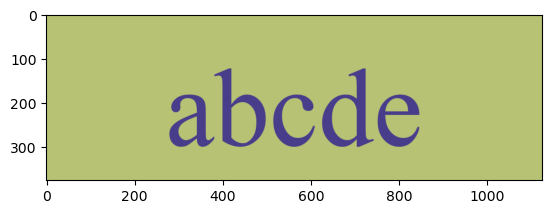

In [25]:
def draw_char(char, typeface, size):
    # Set canvas size
    W, H = (int(size * 1.5) * 3, int(size * 1.5))
    # Set font
    font = ImageFont.truetype(typeface, size)
    # Make empty image
    img = Image.new('RGB', (W, H), color='#B7C274')
    # Draw text to image
    draw = ImageDraw.Draw(img)
    _, _, w, h = font.getbbox(char)
    draw.text(((W-w)/2,(H-h)/2), char, fill='#483d8b', font=font)

    return np.asarray(img)

img = draw_char("abcde", '../inputs/times.ttf', 250)
plt.imshow(img)
plt.show()

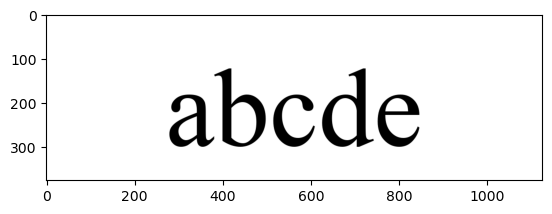

In [54]:
def draw_char(char, typeface, size):
    # Set canvas size
    W, H = (int(size * 1.5) * 3, int(size * 1.5))
    # Set font
    font = ImageFont.truetype(typeface, size)
    # Make empty image
    img = Image.new('RGB', (W, H), color='white')
    # Draw text to image
    draw = ImageDraw.Draw(img)
    _, _, w, h = font.getbbox(char)
    draw.text(((W-w)/2,(H-h)/2), char, fill='black', font=font)

    return np.asarray(img)

img = draw_char("abcde", '../inputs/times.ttf', 250)
plt.imshow(img)
plt.show()

In [47]:
def generate_text(_char):
    return _char * 4

In [50]:
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [57]:
dictionary = {
    'a': 'apple',
    'b': 'ball',
    'c': 'cat',
    'd': 'duck',
    'e': 'eagle',
    'f': 'frog',
    'g': 'goat',
    'h': 'hat',
    'i': 'ice',
    'j': 'jar',
    'k': 'kite',
    'l': 'lamp',
    'm': 'mouse',
    'n': 'nest',
    'o': 'owl',
    'p': 'paint',
    'q': 'queen',
    'r': 'robot',
    's': 'socks',
    't': 'towel',
    'u': 'under',
    'v': 'violin',
    'w': 'wagon',
    'x': 'xenia',
    'y': 'yoyo',
    'z': 'zebra',
    'A': 'APPLE',
    'B': 'BALL',
    'C': 'CAT',
    'D': 'DUCK',
    'E': 'EAGLE',
    'F': 'FROG',
    'G': 'GOAT',
    'H': 'HAT',
    'I': 'ICE',
    'J': 'JAR',
    'K': 'KITE',
    'L': 'LAMP',
    'M': 'MOUSE',
    'N': 'NEST',
    'O': 'OWL',
    'P': 'PAINT',
    'Q': 'QUEEN',
    'R': 'ROBOT',
    'S': 'SOCKS',
    'T': 'TOWEL',
    'U': 'UNDER',
    'V': 'VIOLIN',
    'W': 'WAGON',
    'X': 'XENIA',
    'Y': 'YOYO',
    'Z': 'ZEBRA',
    '1': '1 year',
    '2': '2 years',
    '3': '3 years',
    '4': '4 years',
    '5': '5 years',
    '6': '6 years',
    '7': '7 years',
    '8': '8 years',
    '9': '9 years',
    '0': '0 year',
}

[word for char, word in dictionary.items() if word[0]!=char]

[]

# Define error with non lowercasing

In [62]:
# Get list possible character
chars = list(string.digits + string.ascii_letters)

# Setup problematic font map
hashmap = dict()

# Loop through characters
for char in tqdm(chars):
    # Render characters
    img = draw_char(dictionary[char], '../inputs/times.ttf', 250)
    # Detect characters with OCR
    result = reader.readtext(img, allowlist=chars)

    # If character detected
    if len(result) > 0:
        # Calculate most character appear
        # most_char, total = collections.Counter(result[0][1]).most_common(1)[0]
        most_char = result[0][1][0]
        # If char not the same
        if most_char != char:
            # Add to hash map
            hashmap[char] = most_char

print("Total error", len(hashmap))

100%|██████████| 62/62 [00:05<00:00, 12.32it/s]

Total error 1


Xenia
x --> X


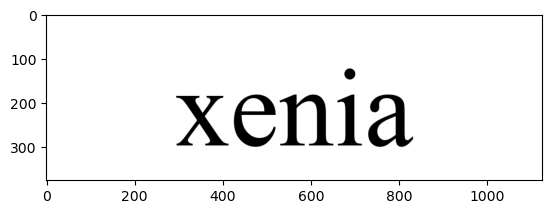

In [66]:
for char, most_char in hashmap.items():
    # Render characters
    img = draw_char(dictionary[char], '../inputs/times.ttf', 250)
    # Detect characters with OCR
    result = reader.readtext(img, allowlist=chars)
    print(result[0][1])

    # Print char
    print(char, "-->", most_char)
    plt.imshow(img, cmap='gray')
    plt.show()

# Define error with lowercasing

In [59]:
# Get list possible character
chars = list(string.digits + string.ascii_letters)

# Setup problematic font map
hashmap = dict()

# Loop through characters
for char in tqdm(chars):
    # Render characters
    img = draw_char(dictionary[char], '../inputs/times.ttf', 250)
    # Detect characters with OCR
    result = reader.readtext(img, allowlist=chars)

    # If character detected
    if len(result) > 0:
        # Calculate most character appear
        # most_char, total = collections.Counter(result[0][1]).most_common(1)[0]
        most_char = result[0][1][0]
        # If char not the same
        if most_char.lower() != char.lower():
            # Add to hash map
            hashmap[char] = most_char

print("Total error", len(hashmap))

100%|██████████| 62/62 [00:04<00:00, 12.65it/s]

Total error 0


In [61]:
for char, most_char in hashmap.items():
    # Render characters
    img = draw_char(generate_text(char), '../inputs/times.ttf', 250)
    # Detect characters with OCR
    result = reader.readtext(img, allowlist=chars)

    # Print char
    print(char, "-->", result[0][1])
    plt.imshow(img, cmap='gray')
    plt.show()

# Generate image

In [11]:
# Get list possible character
chars = list(string.digits + string.ascii_letters)
size = 255

for char in chars:
    # Set canvas size
    W, H = size, size
    # Set font
    font = ImageFont.truetype('../inputs/times.ttf', size)
    # Make empty image
    img = Image.new('L', (W, H), color='white')
    # Draw text to image
    draw = ImageDraw.Draw(img)
    _, _, w, h = font.getbbox(char)
    draw.text(((W-w)/2, ((H-h)/2)-size/10), char, 0, font=font)

    img.save("../chars/" + char + ".png")

# Testing Color

In [12]:
def get_complementary(color):
    if not isinstance(color, str):
        r,g,b = color
        color = "#%02x%02x%02x" % (r,g,b)

    color = color[1:]
    color = int(color, 16)
    comp_color = 0xFFFFFF ^ color
    comp_color = "#%06X" % comp_color
    return comp_color

In [13]:
colors1 = list(ImageColor.colormap.values())
colors2 = [get_complementary(color) for color in colors1]
# pairs = result = [(c1, c2) for c1 in colors for c2 in colors if c1 != c2]
pairs = list(zip(colors1 + colors2, colors2 + colors1))

In [15]:
# Get list possible character
chars = list(string.digits + string.ascii_letters)
hashmaps = []

with tqdm(total=len(pairs) * len(chars)) as pbar:
    for fg, bg in pairs:
        def draw_char(char, typeface, size):
            # Set canvas size
            W, H = (int(size * 1.5) * 3, int(size * 1.5))
            # Set font
            font = ImageFont.truetype(typeface, size)
            # Make empty image
            img = Image.new('RGB', (W, H), color=bg)
            # Draw text to image
            draw = ImageDraw.Draw(img)
            _, _, w, h = font.getbbox(char)
            draw.text(((W-w)/2,(H-h)/2), char, fill=fg, font=font)

            return np.asarray(img)

        # Setup problematic font map
        hashmap = dict()

        # Loop through characters
        for char in chars:
            # Render characters
            img = draw_char(generate_text(char), '../inputs/times.ttf', 250)
            # Detect characters with OCR
            result = reader.readtext(img, allowlist=chars)

            # If character detected
            if len(result) > 0 and len(result[0][1]) > 0:
                # Calculate most character appear
                most_char, total = collections.Counter(result[0][1]).most_common(1)[0]
                # If char not the same
                if most_char.lower() != char.lower():
                    # Add to hash map
                    hashmap[char] = most_char
            else:
                hashmap[char] = ''

            # Update progress bar
            pbar.update(1)

        hashmaps.append(hashmap)

100%|██████████| 18352/18352 [23:35<00:00, 12.96it/s]


In [16]:
hashmaps_count = np.array([len(el) for el in hashmaps])

In [22]:
np.where(hashmaps_count == 0)[0]

array([ 13,  35, 126, 142, 175, 177, 190, 191, 216, 223, 269], dtype=int64)

In [21]:
np.where(np.array(hashmaps) == {})[0]

array([ 13,  35, 126, 142, 175, 177, 190, 191, 216, 223, 269], dtype=int64)

In [23]:
for index in np.where(hashmaps_count == 0)[0]:
    fg, bg = pairs[index]

    def draw_char(char, typeface, size):
        # Set canvas size
        W, H = (int(size * 1.5) * 3, int(size * 1.5))
        # Set font
        font = ImageFont.truetype(typeface, size)
        # Make empty image
        img = Image.new('RGB', (W, H), color=bg)
        # Draw text to image
        draw = ImageDraw.Draw(img)
        _, _, w, h = font.getbbox(char)
        draw.text(((W-w)/2,(H-h)/2), char, fill=fg, font=font)

        return np.asarray(img)

    # Setup problematic font map
    hashmap = dict()

    # Loop through characters
    for char in chars:
        # Render characters
        img = draw_char(generate_text(char), '../inputs/times.ttf', 250)
        # Detect characters with OCR
        result = reader.readtext(img, allowlist=chars)

        # If character detected
        if len(result) > 0 and len(result[0][1]) > 0:
            # Calculate most character appear
            most_char, total = collections.Counter(result[0][1]).most_common(1)[0]
            # If char not the same
            if most_char.lower() != char.lower():
                # Add to hash map
                hashmap[char] = most_char

    print(fg, bg, hashmap)

    for char, most_char in hashmap.items():
        # Render characters
        img = draw_char(generate_text(char), '../inputs/times.ttf', 250)

        # Print char
        print(char, "-->", most_char)
        plt.imshow(img, cmap='gray')
        plt.show()

#5f9ea0 #A0615F {}
#483d8b #B7C274 {}
#2e8b57 #D174A8 {}
#ee82ee #117D11 {}
#424894 #bdb76b {}
#AA94D0 #556b2f {}
#969696 #696969 {}
#969696 #696969 {}
#0F7F7F #f08080 {}
#005F85 #ffa07a {}
#437070 #bc8f8f {}


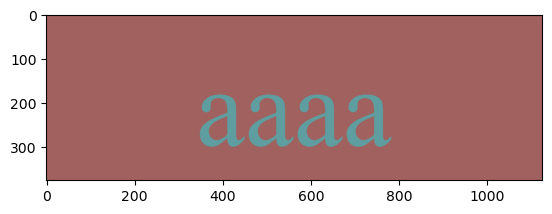

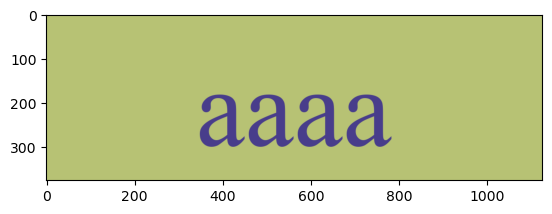

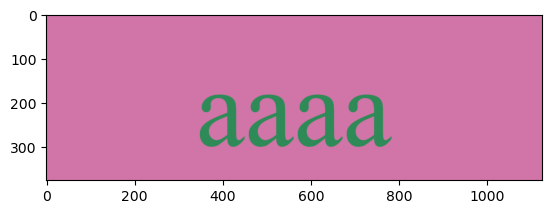

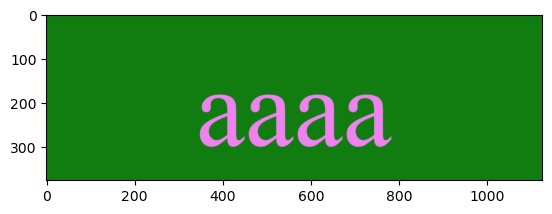

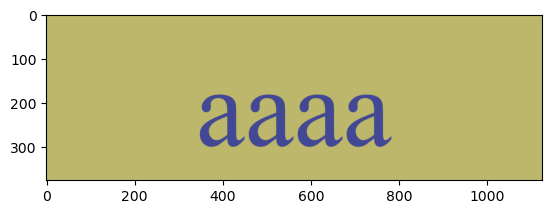

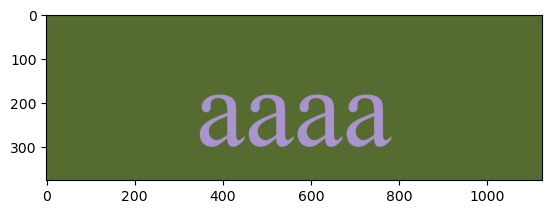

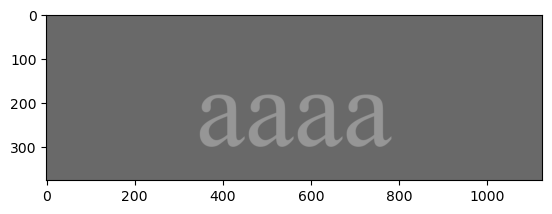

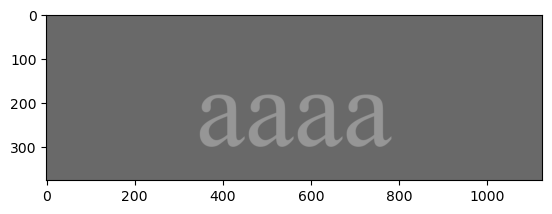

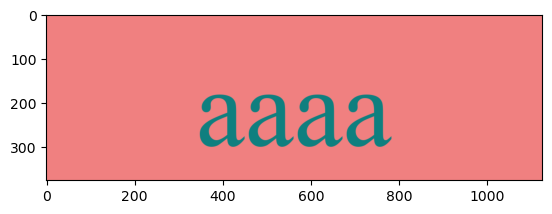

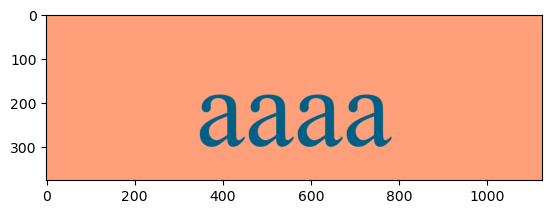

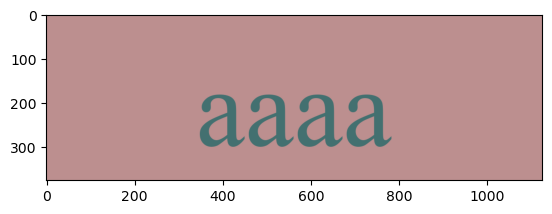

In [24]:
for index in np.where(hashmaps_count == 0)[0]:
    fg, bg = pairs[index]

    def draw_char(char, typeface, size):
        # Set canvas size
        W, H = (int(size * 1.5) * 3, int(size * 1.5))
        # Set font
        font = ImageFont.truetype(typeface, size)
        # Make empty image
        img = Image.new('RGB', (W, H), color=bg)
        # Draw text to image
        draw = ImageDraw.Draw(img)
        _, _, w, h = font.getbbox(char)
        draw.text(((W-w)/2,(H-h)/2), char, fill=fg, font=font)

        return np.asarray(img)

    # Render characters
    img = draw_char(generate_text('a'), '../inputs/times.ttf', 250)

    # Print char
    plt.imshow(img, cmap='gray')
    plt.show()